In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [43]:
def energy(H,A,A_c):
    tmp = A-A_c
    lap = laplacian(A,normed=False)
    return np.trace(tmp.dot(tmp.T)) + np.trace(H.T.dot(lap).dot(H)) + np.trace(A.dot(A.T))
def solve_H(A,P,B,r,cluster=2,optimal = False):
    lap = laplacian(A,normed=False)
    if optimal ==True:
        return np.linalg.eig(lap, eigvals=(0, cluster - 1))
    return np.linalg.solve(lap.T+lap+r*np.identity(lap.shape[0]),r*(P-B))
def solve_A(H,A_c):
    diag_grad = (H**2).sum(axis=1).reshape(-1,1)
    diag_grad = np.tile(diag_grad,(1,A_c.shape[1]))
    res = H.dot(H.T) + 2 * A_c  - diag_grad
    return res/4.0
    

In [4]:
#Create dataset
NOISE = 0.01
N_SAMPLE = 100
data_x, data_y =make_moons(n_samples=N_SAMPLE)
data_x_noisey , data_y_noisy  =make_moons(n_samples=N_SAMPLE,noise=NOISE)

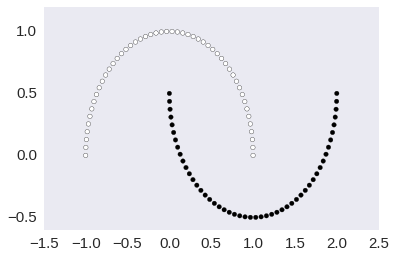

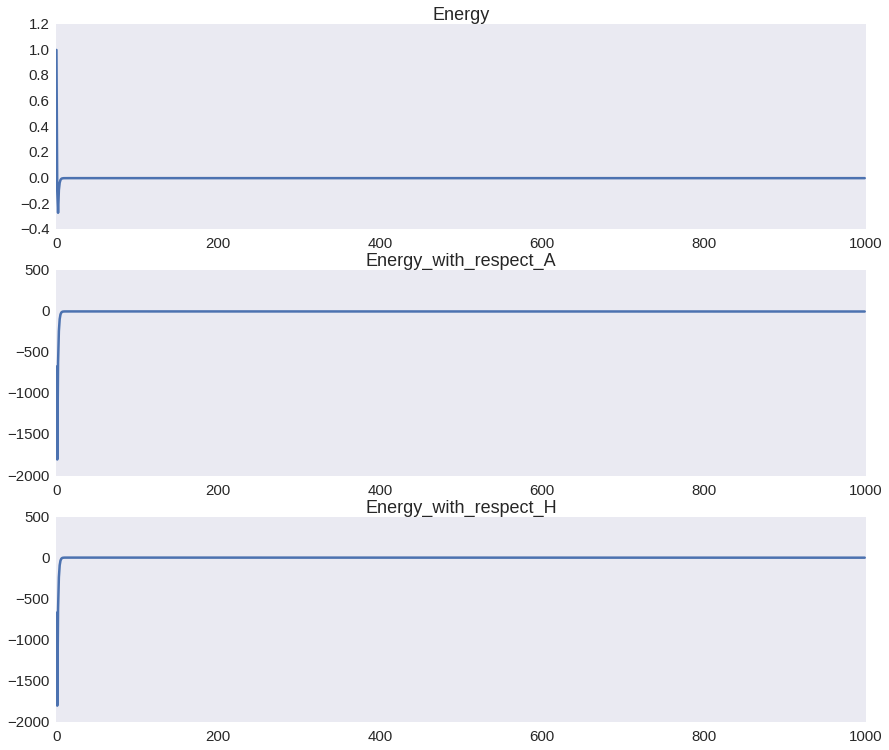

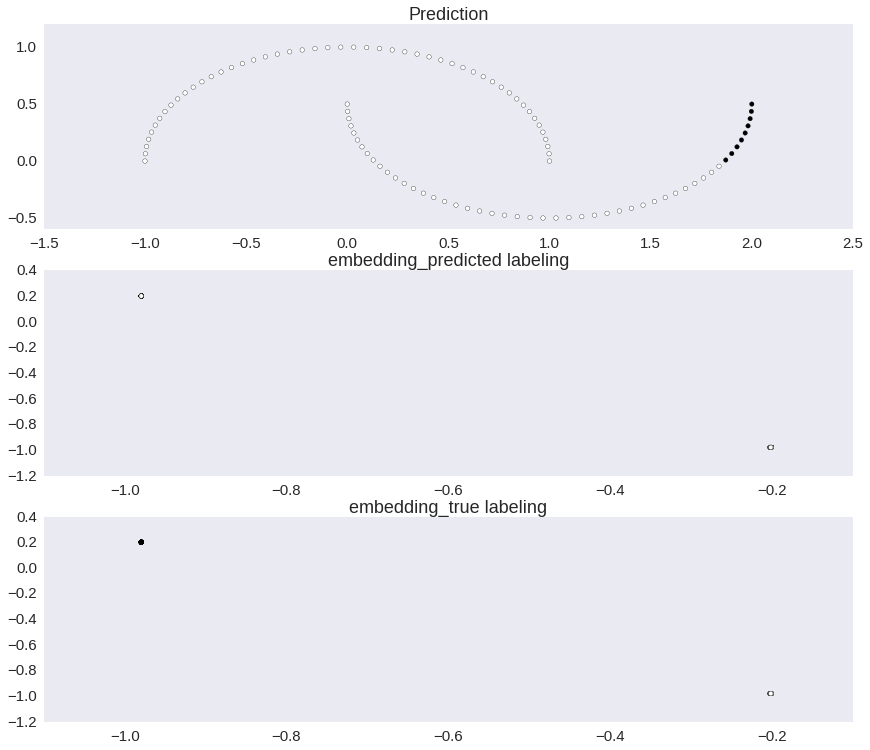

In [5]:
%matplotlib inline
n_samples = 100
plt.scatter(data_x[:,0],data_x[:,1], c =data_y)
fig,ax = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(14.5, 12.5)
ax[0].set_title('Energy')
ax[1].set_title('Energy_with_respect_A')
ax[2].set_title('Energy_with_respect_H')

#Algorithm 
iteration = 1000
r = 1
grad_cof = 0.1
decay_rate = 1.5
k= 5
n_cluster = 2

A_c = kneighbors_graph(data_x,n_neighbors= k,include_self=False).toarray()
#make it symmetric
A_c = 0.5 * (A_c + A_c)
#init
# A = np.random.randint(0,2,A_c.shape[0]**2).reshape(A_c.shape)
A = A_c.copy()
H=np.arange(data_x.shape[0]*n_cluster).reshape(data_x.shape[0],n_cluster)
P = H
B = np.zeros(shape=H.shape)
# 0 main 1:H 2:A
energies  = np.zeros((3,iteration),dtype = np.float)
for iter in range(iteration):
    H_prev = H
    currentEnergy = energy(H, A, A_c)
    energies[0,iter] = currentEnergy
    
    H = solve_H(A,P,B,r)
    energies[1,iter] = energy(H,A,A_c)
    #A = solve_A(H,A_c)
    energies[2,iter] = energy(H,A,A_c)
    y_k = H + B
    u, d, v = np.linalg.svd(y_k, full_matrices=True)
    P = u.dot(np.eye(N=u.shape[1], M=v.shape[0])).dot(v)
    err = np.linalg.norm(H-H_prev)
    if err<0.000005:
        break
    #update
    B = B + H - P
    
kmeans = KMeans(n_cluster)
pred = kmeans.fit_predict(H)
emb  = normalize(H)

    
ax[0].plot(range(iteration),energies[0,:]/energies[0,:].max())
ax[1].plot(range(iteration),energies[1,:]/energies[1,:].max())
ax[2].plot(range(iteration),energies[2,:]/energies[2,:].max())

fig,ax = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(14.5, 12.5)

ax[0].set_title('Prediction')
ax[0].scatter(data_x[:,0],data_x[:,1],c=pred)
ax[1].set_title('embedding_predicted labeling')
ax[1].scatter(emb[:,0],emb[:,1],c=pred)

ax[2].set_title('embedding_true labeling')
ax[2].scatter(emb[:, 0], emb[:, 1], c=data_y)


<IPython.core.display.Javascript object>


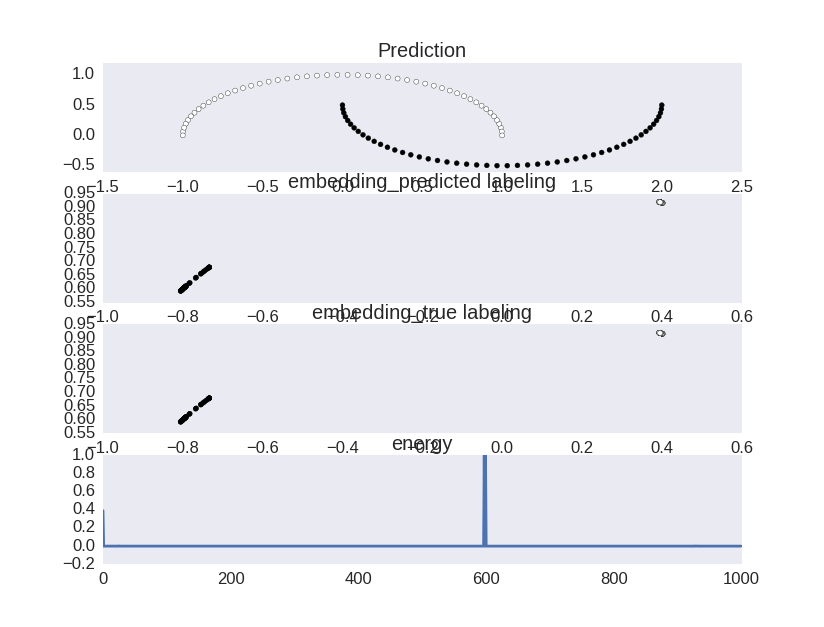

1.0


In [45]:
# np.random.seed(0)
# N_SAMPLE =100
# N_NOISE = 0.0001
# N_NOISE = 0.0001
# neighbor =3
# iteration = 1000
# n_cluster =2
# r=1.0
# data_x, data_y =m #getMoon(n_sample=N_SAMPLE, noise=N_NOISE)#empricalData(n_sample=N_SAMPLE, noise=N_NOISE).getMoon()
r=0.01
iteration = 1000
adj_matrix = kneighbors_graph(data_x,n_neighbors= 5,include_self=False)
adj_matrix = 0.5*(adj_matrix+adj_matrix.T)
laplacianMatrix =laplacian(adj_matrix,normed=False)
A_c = adj_matrix.copy()
#Initializaiton

# H=np.random.randn(X.shape[0],self.n_cluster)
H=np.arange(data_x.shape[0]*n_cluster).reshape(data_x.shape[0],n_cluster)
P = H
row,_ = H.shape
B = np.zeros(shape=H.shape)
energies  = np.zeros((3,iteration),dtype = np.float)

for i in range(iteration):
    currentEnergy = energy(H, A, A_c)
    energies[0,i] = currentEnergy
    H_prev = H.copy()
    H = solve_H(adj_matrix,P,B,r,cluster=n_cluster)#np.linalg.solve((laplacianMatrix+laplacianMatrix.T)+r*np.identity(n=row),r*(P-B))
    
    adj_matrix = solve_A(H,A_c)
    adj_matrix = 0.5*(adj_matrix+adj_matrix)
    new_adj_matrix = 0.5*(adj_matrix+adj_matrix)
    interested_indices = np.where(adj_matrix>0)
    adj_matrix[interested_indices] = new_adj_matrix[interested_indices]
    y_k = H + B
    u, d, v = np.linalg.svd(y_k, full_matrices=True)
    P = u.dot(np.eye(N=u.shape[1], M=v.shape[0])).dot(v)
    err = np.linalg.norm(H-H_prev)
    B = B + H - P
    if err<0.000005:
        print 'threshold meets %f'%err
        break

kmeans = KMeans(n_cluster)
pred = kmeans.fit_predict(H)
emb  = normalize(H)
fig,ax = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(14.5, 12.5)
ax[3].set_title('energy')
ax[3].plot(range(iteration),energies[0,:]/energies[0,:].max())
ax[0].set_title('Prediction')
ax[0].scatter(data_x[:,0],data_x[:,1],c=pred)
ax[1].set_title('embedding_predicted labeling')
ax[1].scatter(emb[:,0],emb[:,1],c=pred)
ax[2].set_title('embedding_true labeling')
ax[2].scatter(emb[:, 0], emb[:, 1], c=data_y)
print np.mean(pred!=~data_y)
plt.show()

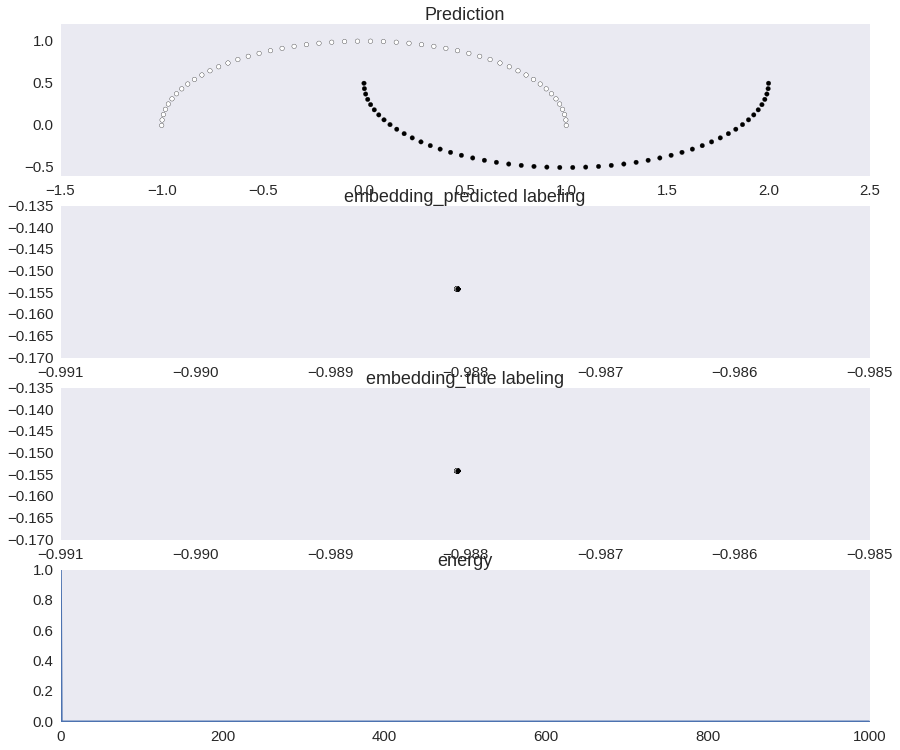

In [12]:
r=0.0000001
iteration = 1000
adj_matrix = kneighbors_graph(data_x,n_neighbors= 5,include_self=False)
adj_matrix = 0.5*(adj_matrix+adj_matrix.T)
laplacianMatrix =laplacian(adj_matrix,normed=False)
A_c = adj_matrix.copy()
#Initializaiton

# H=np.random.randn(X.shape[0],self.n_cluster)
H=np.arange(data_x.shape[0]*n_cluster).reshape(data_x.shape[0],n_cluster)
P = H
row,_ = H.shape
B = np.zeros(shape=H.shape)
energies  = np.zeros((3,iteration),dtype = np.float)

for i in range(iteration):
    currentEnergy = energy(H, A, A_c)
    energies[0,i] = currentEnergy
    H_prev = H.copy()
    H = solve_H(adj_matrix,P,B,r)#np.linalg.solve((laplacianMatrix+laplacianMatrix.T)+r*np.identity(n=row),r*(P-B))
    adj_matrix = solve_A(H,A_c)
    adj_matrix = 0.5*(adj_matrix+adj_matrix)
#       new_adj_matrix = 0.5*(adj_matrix+adj_matrix)

#     interested_indices = np.where(adj_matrix>0)
#     adj_matrix[interested_indices] = new_adj_matrix[interested_indices]
   
#     adj_matrix[adj_matrix>0]=1
#     adj_matrix[adj_matrix<0]=0
    
    y_k = H + B
    u, d, v = np.linalg.svd(y_k, full_matrices=True)
    P = u.dot(np.eye(N=u.shape[1], M=v.shape[0])).dot(v)
    err = np.linalg.norm(H-H_prev)
    B = B + H - P
    if err<0.000005:
        print 'threshold meets %f'%err
        break

kmeans = KMeans(n_cluster)
pred = kmeans.fit_predict(H)
emb  = normalize(H)
fig,ax = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(14.5, 12.5)
ax[3].set_title('energy')
ax[3].plot(range(iteration),energies[0,:]/energies[0,:].max())
ax[0].set_title('Prediction')
ax[0].scatter(data_x[:,0],data_x[:,1],c=pred)
ax[1].set_title('embedding_predicted labeling')
ax[1].scatter(emb[:,0],emb[:,1],c=pred)

ax[2].set_title('embedding_true labeling')
ax[2].scatter(emb[:, 0], emb[:, 1], c=data_y)
plt.show()


<IPython.core.display.Javascript object>


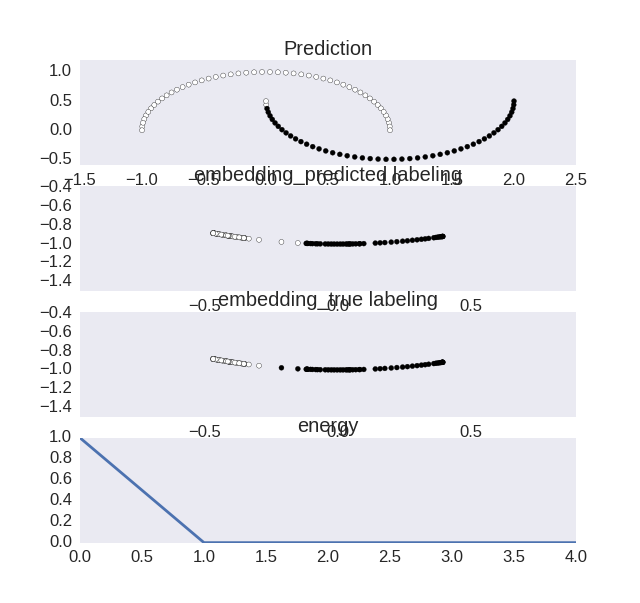

0.98


In [42]:
%matplotlib notebook
np.random.seed(0)
N_SAMPLE =100
dev =0.5
neighbor =10

n_cluster =2
# r=1.0
data_x, data_y =make_moons(n_samples=N_SAMPLE,noise = ) #getMoon(n_sample=N_SAMPLE, noise=N_NOISE)#empricalData(n_sample=N_SAMPLE, noise=N_NOISE).getMoon()

r=0.000000001
iteration = 5
adj_matrix = kneighbors_graph(data_x,n_neighbors= neighbor,include_self=False)
adj_matrix = 0.5*(adj_matrix+adj_matrix.T)
laplacianMatrix =laplacian(adj_matrix,normed=False)
A_c = adj_matrix.copy()
#Initializaiton

# H=np.random.randn(X.shape[0],self.n_cluster)
H=np.arange(data_x.shape[0]*n_cluster).reshape(data_x.shape[0],n_cluster)
P = H
row,_ = H.shape
B = np.zeros(shape=H.shape)
energies  = np.zeros((3,iteration),dtype = np.float)

for i in range(iteration):
    currentEnergy = energy(H, A, A_c)
    energies[0,i] = currentEnergy
    H_prev = H.copy()
    H = solve_H(adj_matrix,P,B,r)#np.linalg.solve((laplacianMatrix+laplacianMatrix.T)+r*np.identity(n=row),r*(P-B))
    adj_matrix = solve_A(H,A_c)
    adj_matrix = 0.5*(adj_matrix+adj_matrix)
    new_adj_matrix = 0.5*(adj_matrix+adj_matrix)

    interested_indices = np.where(adj_matrix>0)
    adj_matrix[interested_indices] = new_adj_matrix[interested_indices]

    
    y_k = H + B
    u, d, v = np.linalg.svd(y_k, full_matrices=True)
    P = u.dot(np.eye(N=u.shape[1], M=v.shape[0])).dot(v)
    err = np.linalg.norm(H-H_prev)
    B = B + H - P
    if np.allclose(H.T.dot(H),np.identity(n=2)):
        print 'hast'
    if err<0.000005:
        print 'threshold meets %f'%err
        break

kmeans = KMeans(n_cluster)
pred = kmeans.fit_predict(normalize(H))
emb  = normalize(H)
fig,ax = plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(14.5, 12.5)
ax[3].set_title('energy')
ax[3].plot(range(iteration),energies[0,:]/energies[0,:].max())
ax[0].set_title('Prediction')
ax[0].scatter(data_x[:,0],data_x[:,1],c=pred)
ax[1].set_title('embedding_predicted labeling')
ax[1].scatter(emb[:,0],emb[:,1],c=pred)
ax[1].set_autoscaley_on(False)
ax[1].set_ylim([emb[:,1].min()-dev,emb[:,1].max()+dev])
ax[1].set_xlim([emb[:,0].min()-dev,emb[:,0].max()+dev])
ax[2].set_title('embedding_true labeling')
ax[2].set_ylim([emb[:,1].min()-dev,emb[:,1].max()+dev])
ax[2].set_xlim([emb[:,0].min()-dev,emb[:,0].max()+dev])
ax[2].scatter(emb[:, 0], emb[:, 1], c=data_y)
print np.mean(pred!=np.logical_not(data_y))


plt.show()